In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
from scipy.spatial.distance import cdist

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Restore pre-trained Convnet model

In [5]:
sess = tf.Session()

In [6]:
saver =  tf.train.import_meta_graph('./tmp/minst_convnet_model.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint('./tmp/'))

INFO:tensorflow:Restoring parameters from ./tmp/minst_convnet_model.ckpt


### Retrieve tensors 

In [7]:
training = sess.graph.get_tensor_by_name('training:0')
x = sess.graph.get_tensor_by_name('Placeholder:0')
y = sess.graph.get_tensor_by_name('Placeholder_1:0')
fc1_relu = sess.graph.get_tensor_by_name('fc1/Relu:0')

### Compute fc1 layer embedding features for MNIST test images

In [8]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
X = mnist.test.images  # Returns np.array
Y = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [9]:
X_fc1_embedding = sess.run(fc1_relu, feed_dict={x: X, training: False})

In [10]:
X_fc1_embedding.shape

(10000, 1024)

In [11]:
sess.close()

### Utility Functions

In [12]:
images_data = np.reshape(X, [-1,28,28,1])

In [13]:
def display_images(idxs):
    try:
        n = len(idxs)
    except TypeError:
        idxs = [idxs]
        n = 1    
    rows = n // 10 + (1 if n % 10 > 0 else 0)
    cols = min(n, 10)
    scale = 2.5
    fig = plt.figure(figsize=(cols * 0.6 * scale, rows * 0.45 * scale))
    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.05)
    for i in range(n):
        r, c = i // 10, i % 10
        ax = fig.add_subplot(gs[r,c])
        ax.imshow(images_data[idxs[i],:,:,0])
        ax.axis('off')
    plt.show()

In [16]:
def retrieve_similar_images(features, query_idx=None, k=10, dist_metric='euclidean'):
    n_test = X.shape[0]
    if query_idx is None:
        query_idx = np.random.randint(0,n_test)
    print('query: idx = %d' % query_idx)
    display_images(query_idx)
    dist = cdist(features, features[query_idx].reshape(1,-1), dist_metric)
    rank = np.argsort(dist.ravel())
    rank_top_k = rank[1:k+1]
    prec = sum(1 if Y[query_idx] == Y[idx] else 0 for idx in rank_top_k) / k
    print('top %d most similars: idxs = %s' % (k, rank_top_k))
    print('precision = %f' % prec)
    display_images(rank_top_k)

## Display some examples

-------------------------
query: idx = 9024


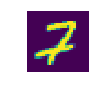

top 30 most similars: idxs = [9036 9009 9019 5127 9031 3767 2628 9044 4504 1283 2016 9045 5120 7154
 8208 2820 9623 5820 2507 3349 7151 7483 9913  888 9015 7486 4736 6713
  950 1349]
precision = 0.533333


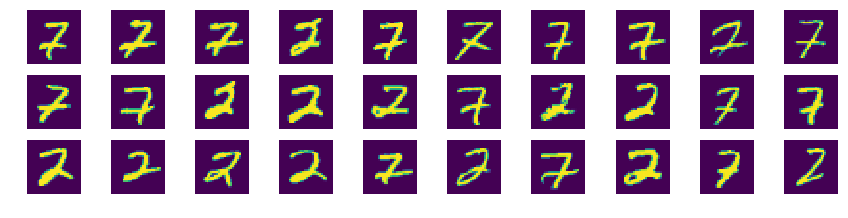

-------------------------
query: idx = 9740


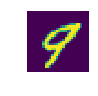

top 30 most similars: idxs = [9252 9741 9767 5106 7136 9255 6747 9723 5135 9544 7243 9214 9924 9973
 5100 4570 7148 7874 9245 6967 7580 6718 5009 8184 8227 4786 6793 9713
 6772 1063]
precision = 1.000000


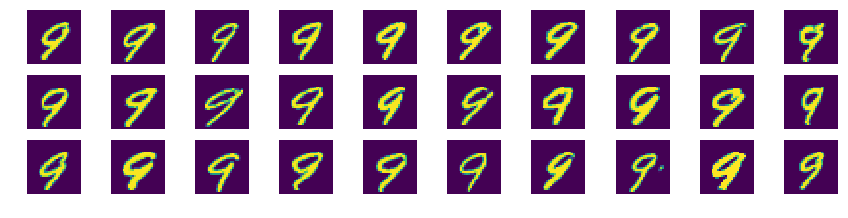

-------------------------
query: idx = 1272


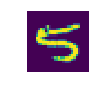

top 30 most similars: idxs = [2773  791 3750 9382 3763 9493 9085 3022 3416 3145 1421 2697 1948 2476
 9119 2247 9133 6146 2805 2134 2021 1221 4368 1510 6909 2030 2445  364
  778 4094]
precision = 1.000000


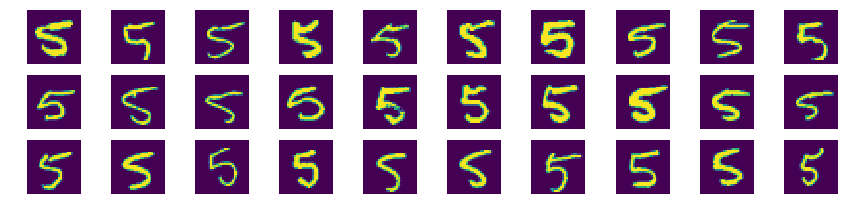

-------------------------
query: idx = 7482


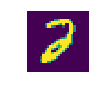

top 30 most similars: idxs = [7486  875 4189 3628 4342 3415 5820 1349 4684  199 4401 7457 6217 6635
 9521 1002 4167 4559 2248 2848 6773 9849 1395 7348 6703  418 2596 7147
 9820  858]
precision = 1.000000


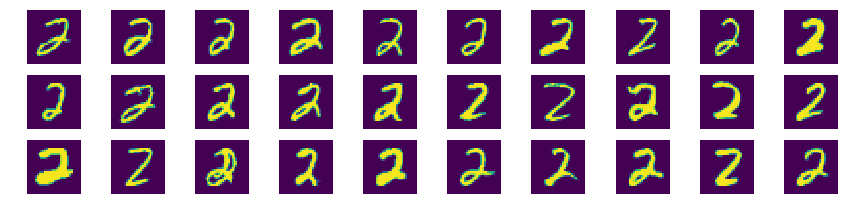

In [40]:
for idx in (9024,9740,1272,7482):
    print('-------------------------')
    retrieve_similar_images(X_fc1_embedding, query_idx=idx, k = 30, dist_metric='cityblock')